In [1]:
train_dir = "/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train"
test_dir = "/kaggle/input/original-ham10000-traintest400/content/HAM10000_Test400/test"

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

2025-04-10 17:31:28.082300: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744306288.277050      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744306288.331169      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
img_width, img_height = 400, 400
batch_size = 32
epochs = 100
num_classes = 196

In [4]:
train_datagen = ImageDataGenerator( rescale=1./255, rotation_range=25, width_shift_range=0.25, 
                                   height_shift_range=0.25, shear_range=0.25, zoom_range=0.25, 
                                   horizontal_flip=True, fill_mode='nearest' )
        

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory( train_dir, 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size, class_mode='categorical', 
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory( test_dir, 
                                                  target_size=(img_width, img_height), 
                                                  batch_size=batch_size, class_mode='categorical', 
                                                  shuffle=False )

Found 8912 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import *

In [6]:
num_heads = 5
reduction_ratio = 8
dropout_rate = 0.02
l2_reg = 0.001
simam_lambda = 0.0001

In [7]:

class SimAM(tf.keras.layers.Layer):
    def __init__(self, eps=0.0001, activation=tf.nn.sigmoid, trainable=True, name=None, **kwargs):
        super(SimAM, self).__init__(name=name, trainable=trainable, **kwargs)
        self.activation = activation
        self.eps = eps

    def build(self, input_shape):
        self.height, self.width, self.channels = input_shape[1], input_shape[2], input_shape[3]
        self.norm = 4. / (self.height * self.width - 1)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        minus_mu_square = tf.square(inputs - tf.reduce_mean(inputs, axis=(1, 2), keepdims=True))
        out = minus_mu_square / tf.maximum(
            tf.reduce_sum(minus_mu_square, axis=(1, 2), keepdims=True) * self.norm,
            self.eps) + 0.5
        return inputs * self.activation(out)

In [8]:
class CSA(layers.Layer):
    def __init__(self, num_heads, channels, dropout_rate=0.02,l2_reg=0.001, **kwargs):
        super(CSA, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.head_channels = channels // num_heads
        self.heads = []

        for _ in range(num_heads):
            self.heads.append(self.build_SA_block(channels=self.head_channels,
                                                              dropout_rate=dropout_rate,
                                                              l2_reg=l2_reg))

        self.simam = SimAM(eps=0.0001, activation=tf.nn.sigmoid)
        self.dropout = layers.Dropout(dropout_rate)
        self.batch_norm = layers.BatchNormalization()

    def build_SA_block(self, channels, dropout_rate, l2_reg):
        input_tensor = tf.keras.Input(shape=(6, 6, channels))

        # Channel-wise attention Global features
        input_channels = channels

        conv_before_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(input_tensor)

        conv_before_attention1 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention0)

        conv_before_attention2 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention0)

        conv_before_attention3 = Multiply()([conv_before_attention1, conv_before_attention2])

        conv_before_attention4 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention3)

        conv_before_attention5 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention3)

        conv_before_attention6 = Multiply()([conv_before_attention4, conv_before_attention5])

        conv_before_attention7 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention6)

        conv_before_attention8 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention6)

        conv_before_attention9 = Multiply()([conv_before_attention7, conv_before_attention8])

        conv_before_attention10 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention9)

        conv_before_attention11 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(conv_before_attention9)

        conv_before_attention12 = Multiply()([conv_before_attention10, conv_before_attention11])

        conv_before_attention12 = Dropout(dropout_rate)(conv_before_attention12)

        avg_pool = GlobalAveragePooling2D()(conv_before_attention12)
        max_pool = GlobalMaxPooling2D()(conv_before_attention12)
        concat = Concatenate()([avg_pool, max_pool])

        sequential_attention = Reshape((1, 1, concat.shape[-1]))(concat)
        sequential_attention = Lambda(lambda x: tf.keras.backend.repeat_elements(x, rep=6, axis=1))(sequential_attention)
        sequential_attention = Lambda(lambda x: tf.keras.backend.repeat_elements(x, rep=6, axis=2))(sequential_attention)

        sequential_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                                       depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                       padding='same')(sequential_attention)

        sequential_attention1 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention0)

        sequential_attention2 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention0)

        sequential_attention3 = Multiply()([sequential_attention1, sequential_attention2])

        sequential_attention4 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention3)

        sequential_attention5 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention3)

        sequential_attention6 = Multiply()([sequential_attention4, sequential_attention5])

        sequential_attention7 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention6)

        sequential_attention8 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention6)

        sequential_attention9 = Multiply()([sequential_attention7, sequential_attention8])

        sequential_attention10 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention9)

        sequential_attention11 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention9)

        sequential_attention12 = Multiply()([sequential_attention10, sequential_attention11])

        sequential_attention12 = Dropout(dropout_rate)(sequential_attention12)

        sequential_attention13 = Concatenate()([conv_before_attention12, sequential_attention12])

        # Row-wise attention
        row_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        row_attention1 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention0)

        row_attention2 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention1)

        row_attention3 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention2)

        row_attention4 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention3)

        row_attention4 = Dropout(dropout_rate)(row_attention4)

        row_attention5 = Concatenate()([sequential_attention13, row_attention4])

        # Column-wise attention
        col_attention0 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        col_attention1 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention0)

        col_attention2 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention1)

        col_attention3 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention2)

        col_attention4 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention3)

        col_attention4 = Dropout(dropout_rate)(col_attention4)

        col_attention5 = Concatenate()([sequential_attention13, col_attention4])

        # Combine row and column attentions
        sequential_attention14 = Multiply()([row_attention5, col_attention5])
        sequential_attention14 = Dropout(dropout_rate)(sequential_attention14)

        conv_after_attention0 = DepthwiseConv2D( kernel_size=(1, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(sequential_attention14)

        conv_after_attention1 = DepthwiseConv2D( kernel_size=(1, 2), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention0)

        conv_after_attention2 = DepthwiseConv2D( kernel_size=(2, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention0)

        conv_after_attention3 = Multiply()([conv_after_attention1, conv_after_attention2])

        conv_after_attention4 = DepthwiseConv2D( kernel_size=(1, 3), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention3)

        conv_after_attention5 = DepthwiseConv2D( kernel_size=(3, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention3)

        conv_after_attention6 = Multiply()([conv_after_attention4, conv_after_attention5])

        conv_after_attention7 = DepthwiseConv2D( kernel_size=(1, 4), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention6)

        conv_after_attention8 = DepthwiseConv2D( kernel_size=(4, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention6)

        conv_after_attention9 = Multiply()([conv_after_attention7, conv_after_attention8])

        conv_after_attention10 = DepthwiseConv2D( kernel_size=(1, 5), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention9)

        conv_after_attention11 = DepthwiseConv2D( kernel_size=(5, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention9)

        conv_after_attention12 = Multiply()([conv_after_attention10,
                                                     conv_after_attention11])

        conv_after_attention12 = Dropout(dropout_rate)(conv_after_attention12)

        conv_after_attention12 = Concatenate()([conv_before_attention12, conv_after_attention12])

        # Channel-wise attention local features
        sequential_attention15 = DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                                       depthwise_initializer='he_normal',
                                       depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                       padding='same')(conv_after_attention12)

        sequential_attention16 = DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention15)

        sequential_attention17 = DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention15)

        sequential_attention18 = Multiply()([sequential_attention16, sequential_attention17])

        sequential_attention19 = DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention18)

        sequential_attention20 = DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention18)

        sequential_attention21 = Multiply()([sequential_attention19, sequential_attention20])

        sequential_attention22 = DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention21)

        sequential_attention23 = DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention22)

        sequential_attention24 = Multiply()([sequential_attention22, sequential_attention23])

        sequential_attention25 = DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention24)

        sequential_attention26 = DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                                        depthwise_initializer='he_normal',
                                        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                        padding='same')(sequential_attention24)

        sequential_attention27 = Multiply()([sequential_attention25, sequential_attention26])

        sequential_attention27 = Dropout(dropout_rate)(sequential_attention27)

        sequential_attention28 = Concatenate()([conv_before_attention12, sequential_attention27])

        # Row-wise attention
        row_attention6= DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        row_attention7= DepthwiseConv2D(kernel_size=(1, 2), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention6)

        row_attention8= DepthwiseConv2D(kernel_size=(1, 3), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention7)

        row_attention9= DepthwiseConv2D(kernel_size=(1, 4), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention8)

        row_attention10= DepthwiseConv2D(kernel_size=(1, 5), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(row_attention9)

        row_attention10 = Dropout(dropout_rate)(row_attention10)
        row_attention11 = Concatenate()([sequential_attention28, row_attention10])

        # Column-wise attention
        col_attention6= DepthwiseConv2D(kernel_size=(1, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(conv_before_attention12)

        col_attention7= DepthwiseConv2D(kernel_size=(2, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention6)

        col_attention8= DepthwiseConv2D(kernel_size=(3, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention7)

        col_attention9= DepthwiseConv2D(kernel_size=(4, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention8)

        col_attention10= DepthwiseConv2D(kernel_size=(5, 1), activation='sigmoid',
                               depthwise_initializer='he_normal', depthwise_regularizer=regularizers.l2(l2_reg),
                               padding='same')(col_attention9)

        col_attention10= Dropout(dropout_rate)(col_attention10)
        col_attention11= Concatenate()([sequential_attention28, col_attention10])

        # Combine row and column attentions
        sequential_attention29=Multiply()([row_attention11, col_attention11])
        sequential_attention29=Dropout(dropout_rate)(sequential_attention29)

        conv_after_attention13 = DepthwiseConv2D( kernel_size=(1, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(sequential_attention29)

        conv_after_attention14= DepthwiseConv2D( kernel_size=(1, 2), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention13)

        conv_after_attention15= DepthwiseConv2D( kernel_size=(2, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention13)

        conv_after_attention16=Multiply()([conv_after_attention14, conv_after_attention15])

        conv_after_attention17= DepthwiseConv2D( kernel_size=(1, 3), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention16)

        conv_after_attention18= DepthwiseConv2D( kernel_size=(3, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention16)

        conv_after_attention19=Multiply()([conv_after_attention17, conv_after_attention18])

        conv_after_attention20= DepthwiseConv2D( kernel_size=(1, 4), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention19)

        conv_after_attention21= DepthwiseConv2D( kernel_size=(4, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention19)

        conv_after_attention22=Multiply()([conv_after_attention20, conv_after_attention21])

        conv_after_attention23= DepthwiseConv2D( kernel_size=(1, 5), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention22)

        conv_after_attention24= DepthwiseConv2D( kernel_size=(5, 1), activation='sigmoid',
                                            depthwise_initializer='he_normal',
                                              depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
                                            padding='same')(conv_after_attention23)

        conv_after_attention25=Multiply()([conv_after_attention23,
                                                   conv_after_attention24])

        conv_after_attention25= Dropout(dropout_rate)(conv_after_attention25)

        conv_after_attention25 = Concatenate()([conv_before_attention12, conv_after_attention25])

        dual_sequential_attention = Concatenate()([conv_after_attention12, conv_after_attention25])

        dual_sequential_attention = BatchNormalization()(dual_sequential_attention)
        dual_sequential_attention = Dropout(dropout_rate)(dual_sequential_attention)

        return tf.keras.Model(inputs=input_tensor, outputs=dual_sequential_attention)

    def call(self, inputs):
        head_outputs = []

        for i in range(self.num_heads):
            head_input = inputs[:, :, :, i * self.head_channels:(i + 1) * self.head_channels]
            head_output = self.heads[i](head_input)
            head_outputs.append(head_output)

        cbam_attention = Concatenate()(head_outputs)
        simam_attention = self.simam(inputs)

        fused_attention = tf.concat([cbam_attention, simam_attention], axis=-1)
        fused_attention = self.dropout(fused_attention)
        fused_attention = self.batch_norm(fused_attention)

        return fused_attention

In [9]:
from tensorflow.keras.layers import Lambda, DepthwiseConv2D, BatchNormalization, Dropout, Reshape, UpSampling2D, Multiply

In [10]:
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = base_model.output
x = BatchNormalization()(x)
x = Dropout(0.02)(x)
print(x.shape)

x = layers.AveragePooling2D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)
print(x.shape)

x = SeparableConv2D( 512, kernel_size=(5, 5), activation='sigmoid',
            depthwise_initializer='he_normal', pointwise_initializer='he_normal',
            depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
            pointwise_regularizer=tf.keras.regularizers.l2(l2_reg),
            padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)
print(x.shape)

x = CSA(num_heads, 512, dropout_rate, l2_reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)
print("attention",x.shape)

x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.02)(x)
print(x.shape)

preds = Dense(units=7, activation='softmax')(x)
model1 = tf.keras.Model(inputs=base_model.input, outputs=preds)

I0000 00:00:1744306309.564860      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 12, 12, 1920)
(None, 6, 6, 1920)
(None, 6, 6, 512)
attention (None, 6, 6, 7142)
(None, 7142)


In [11]:
for layer in model1.layers:
    layer.trainable = True

In [12]:
model1.load_weights("/kaggle/input/93-20-densenet201-simsanet-ham10k/93.20_DenseNet201_SimSANet_ham10k.weights.h5")

In [13]:
model1.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
              metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('DenseNet201_SimSANet_Oral.weights.h5', monitor='val_accuracy', 
                             save_best_only = True, save_weights_only = True, mode ='max', verbose = 2)

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 15, mode = 'max', verbose = 2)

reduce_learning_rate=ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.1, patience = 10, verbose = 2)

In [14]:
total_params = model1.count_params()
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 19942189


In [15]:
trainable_params = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model1.trainable_variables])
print(f"Trainable parameters in the model: {trainable_params}")

Trainable parameters in the model: 19648317


In [16]:
non_trainable_params = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model1.non_trainable_weights])
print(f"Non-trainable parameters in the model: {non_trainable_params}")

Non-trainable parameters in the model: 293872


In [ ]:
import time
start_time = time.time()

history=model1.fit(train_generator, epochs = 100, validation_data = test_generator,
                  callbacks = [checkpoint, early_stop, reduce_learning_rate])

end_time = time.time()
preprocessing_time = end_time - start_time

print("Preprocessing completed. Time taken:", preprocessing_time, "seconds")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6333 - loss: 2.5110 - mse: 0.2717 
Epoch 1: val_accuracy improved from -inf to 0.63101, saving model to DenseNet201_SimSANet_Oral.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 1876s 12s/step - accuracy: 0.6339 - loss: 2.5091 - mse: 0.2712 - val_accuracy: 0.6310 - val_loss: 2.1969 - val_mse: 0.2708 - learning_rate: 1.0000e-04
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7064 - loss: 2.1122 - mse: 0.2183
Epoch 2: val_accuracy did not improve from 0.63101
81/81 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7066 - loss: 2.1108 - mse: 0.2181 - val_accuracy: 0.6310 - val_loss: 2.0550 - val_mse: 0.2852 - learning_rate: 1.0000e-04
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7431 - loss: 1.8302 - mse: 0.1900
Epoch 3: val_accuracy did not improve from 0.63101
81/81 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7432 - loss: 1.8295 - mse: 0.1900 - val_accuracy: 0.6310 - val_loss: 1.8972 - val_mse: 0.2854 - lear

In [17]:
test_result = model1.evaluate(test_generator)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744306360.408957     106 service.cc:148] XLA service 0x7da8e8002a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744306360.409739     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744306364.746521     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-10 17:32:58.151312: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,896,25,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1792,25,25]{3,2,1,0}, f32[896,1792,1,1]{3,2,1,0}), window={size=

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8716 - loss: 0.7620 - mse: 0.0308

E0000 00:00:1744306412.400711     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744306412.637198     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8749 - loss: 0.7464 - mse: 0.0300
Test Loss: 0.4824812412261963
Test Accuracy: 0.9320036172866821


In [24]:
print("Classification Report:")
print(report)

Classification Report:


NameError: name 'report' is not defined

In [25]:
# Extracting metrics using classification_report
metrics = classification_report(true_labels, predicted_labels, output_dict=True)

NameError: name 'true_labels' is not defined

In [18]:
def print_model_layer_names(model):
    for layer in model.layers:
        print(layer.name)

# Assuming 'model1' is your model
print_model_layer_names(model1)

input_layer
zero_padding2d
conv1_conv
conv1_bn
conv1_relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
con

/tmp/ipykernel_31/340223599.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


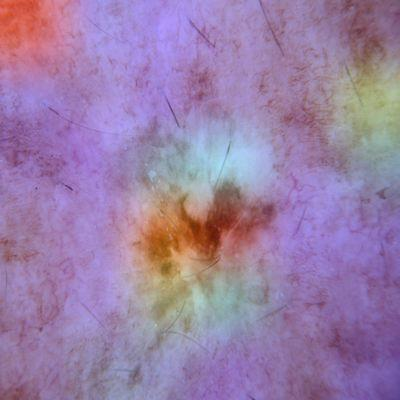

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/akiec/ISIC_0024575.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

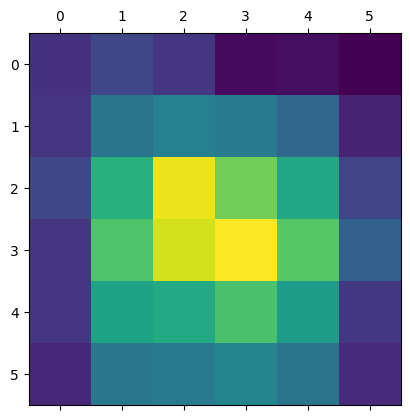

/tmp/ipykernel_31/2150253366.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


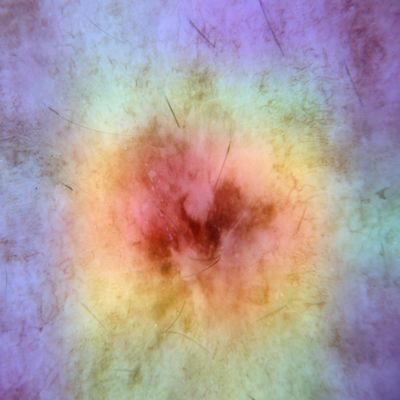

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/akiec/ISIC_0024575.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

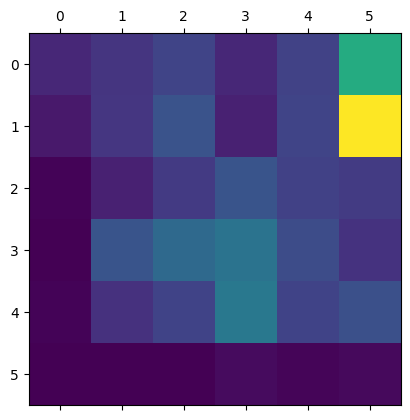

/tmp/ipykernel_31/605357858.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


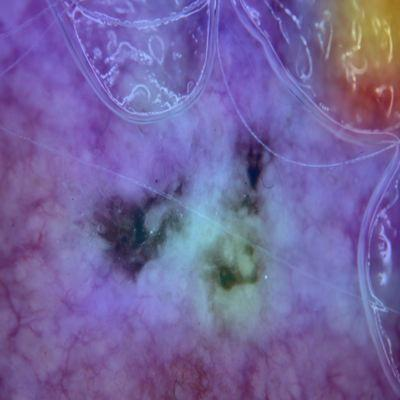

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/akiec/ISIC_0031119.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

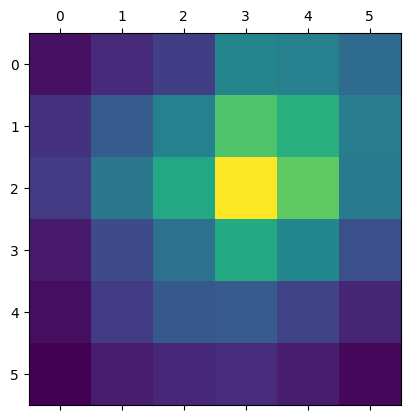

/tmp/ipykernel_31/3125403669.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


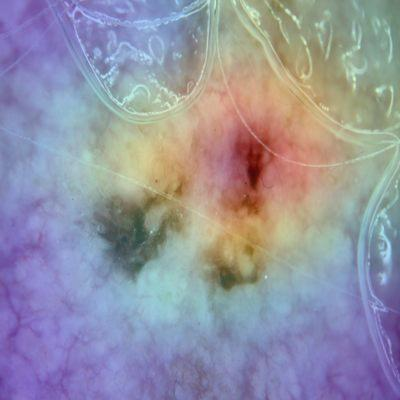

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/akiec/ISIC_0031119.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

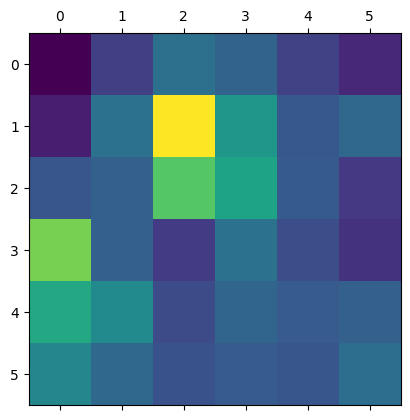

/tmp/ipykernel_31/3817350454.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


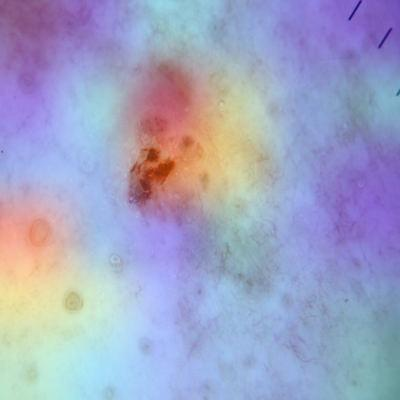

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bcc/ISIC_0031062.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

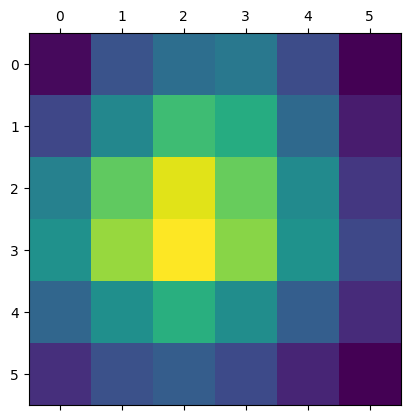

/tmp/ipykernel_31/1158752076.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


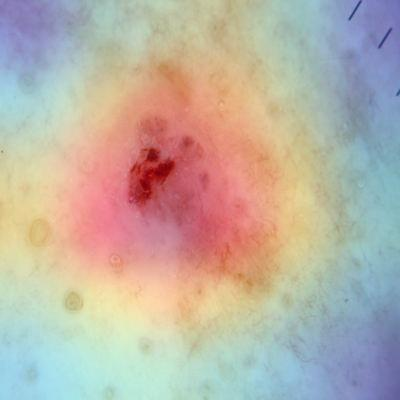

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bcc/ISIC_0031062.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

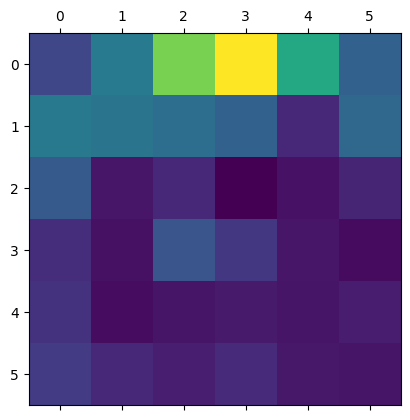

/tmp/ipykernel_31/1672753540.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


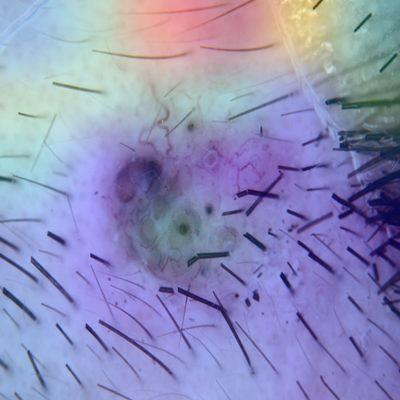

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bcc/ISIC_0030528.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

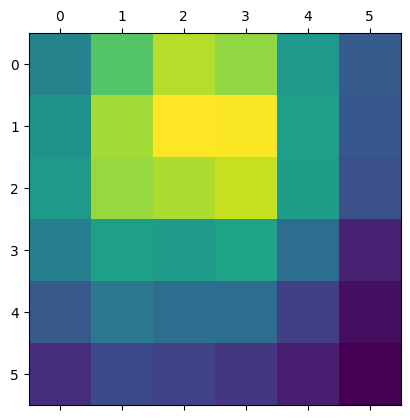

/tmp/ipykernel_31/620290307.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


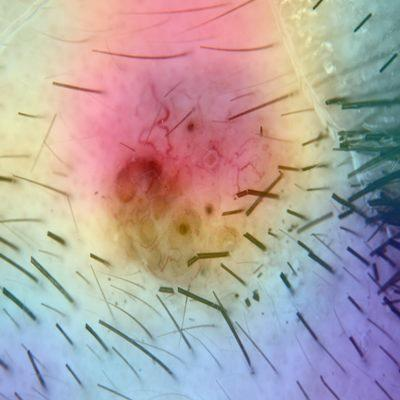

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bcc/ISIC_0030528.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

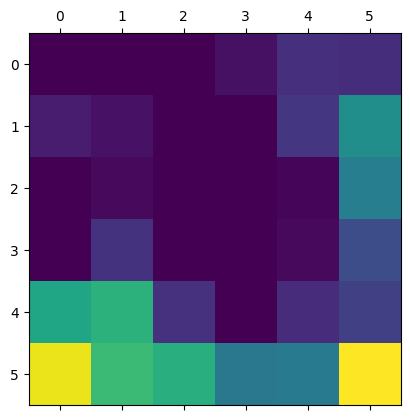

/tmp/ipykernel_31/349639988.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


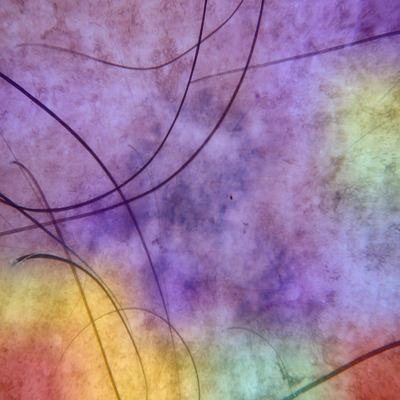

In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bkl/ISIC_0025075.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

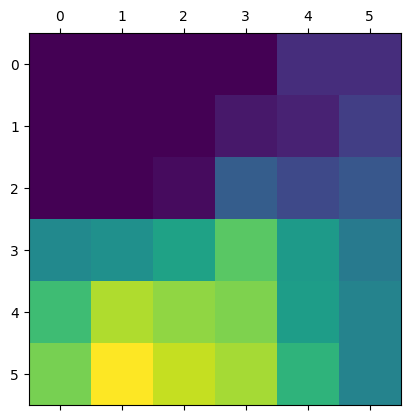

/tmp/ipykernel_31/3828847412.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


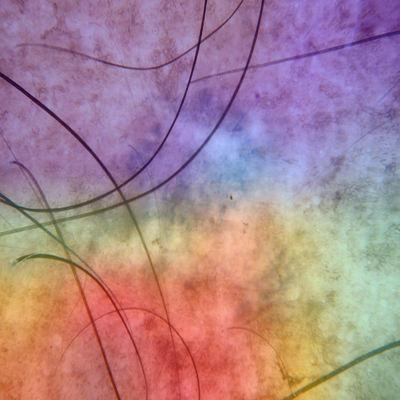

In [44]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bkl/ISIC_0025075.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

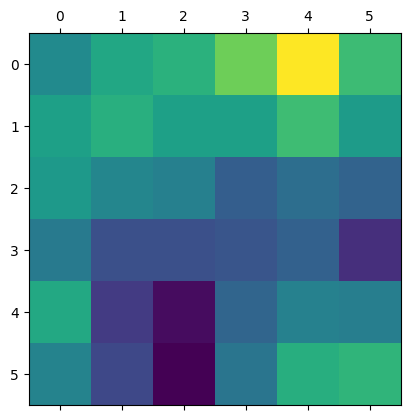

/tmp/ipykernel_31/1071930894.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


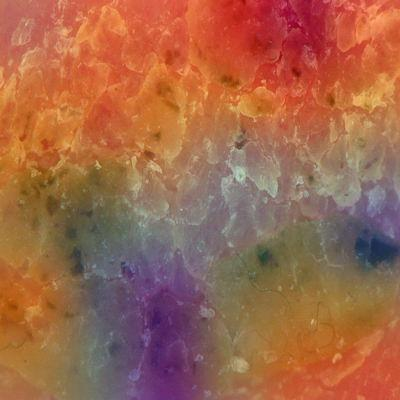

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bkl/ISIC_0026042.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

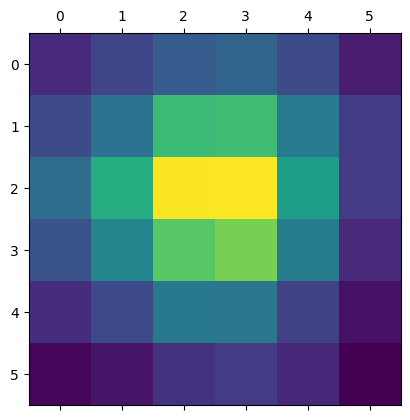

/tmp/ipykernel_31/3418164699.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


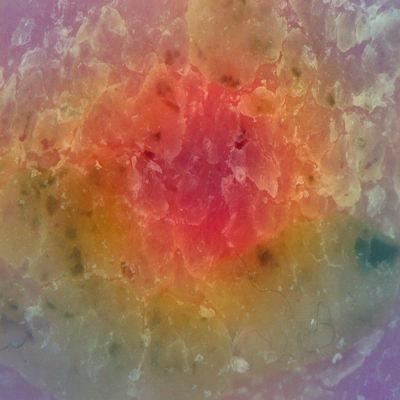

In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/bkl/ISIC_0026042.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

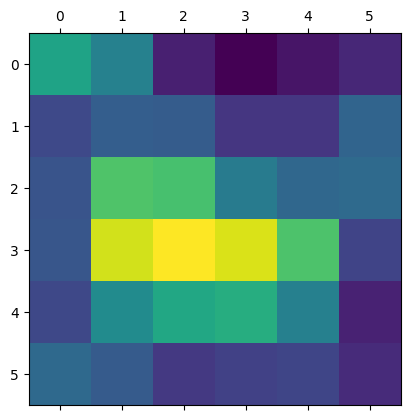

/tmp/ipykernel_31/4101982723.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


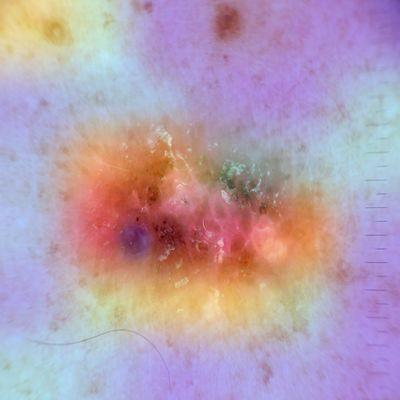

In [55]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/df/ISIC_0028790.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

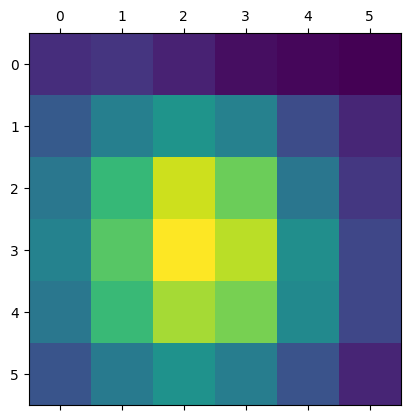

/tmp/ipykernel_31/3070483443.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


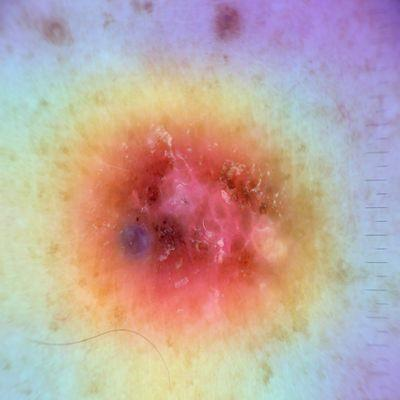

In [56]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/df/ISIC_0028790.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

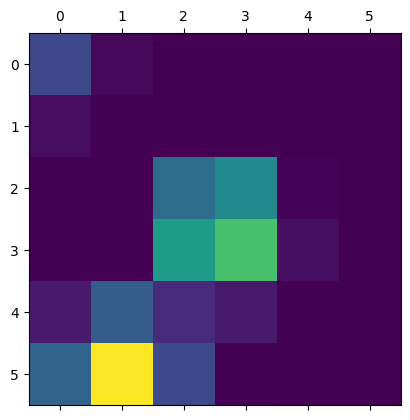

/tmp/ipykernel_31/1412148188.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


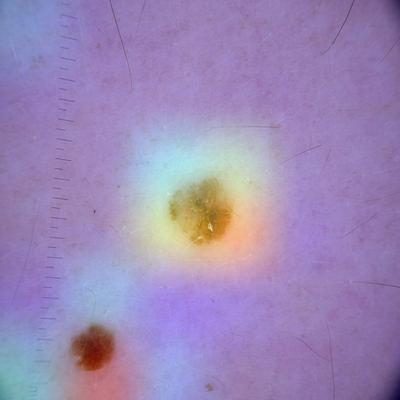

In [61]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/mel/ISIC_0031406.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

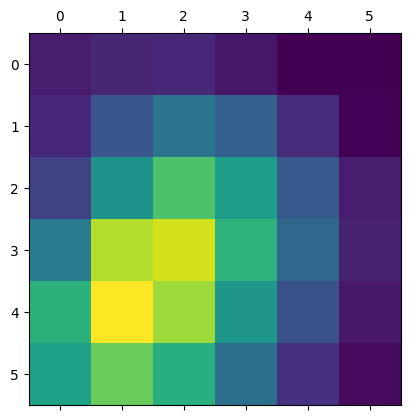

/tmp/ipykernel_31/4274164857.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


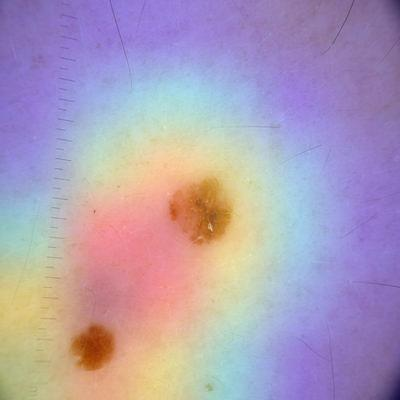

In [62]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/mel/ISIC_0031406.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

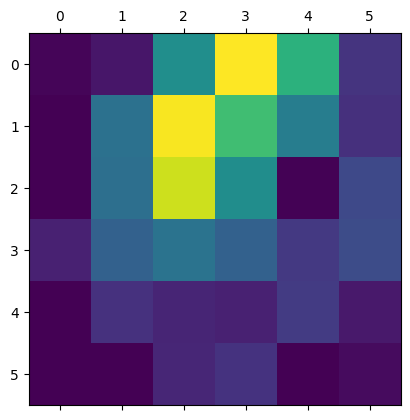

/tmp/ipykernel_31/941619609.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


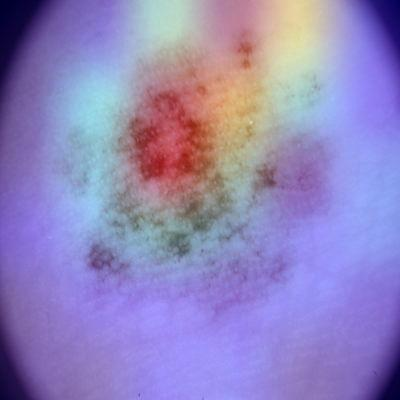

In [67]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0033013.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

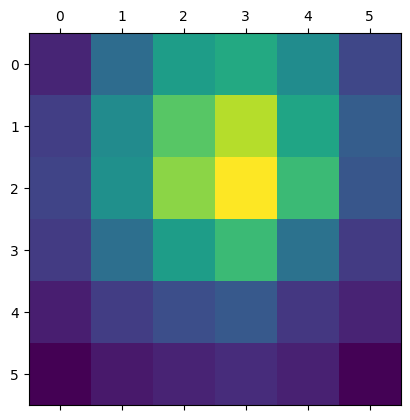

/tmp/ipykernel_31/3681594710.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


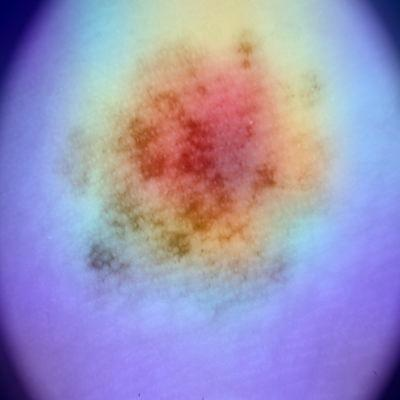

In [69]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0033013.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

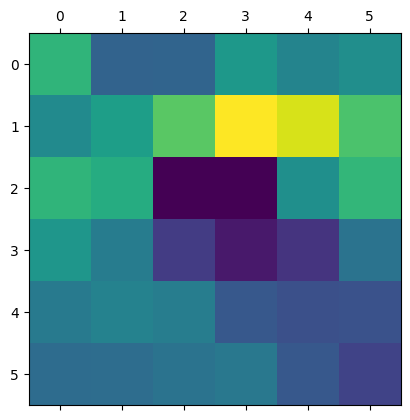

/tmp/ipykernel_31/3491291216.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


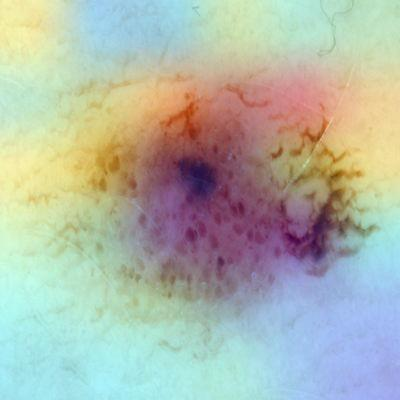

In [70]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032878.jpg'
last_conv_layer_name = 'dropout_1'
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

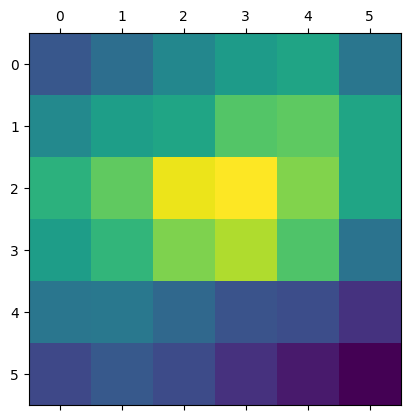

/tmp/ipykernel_31/834006028.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


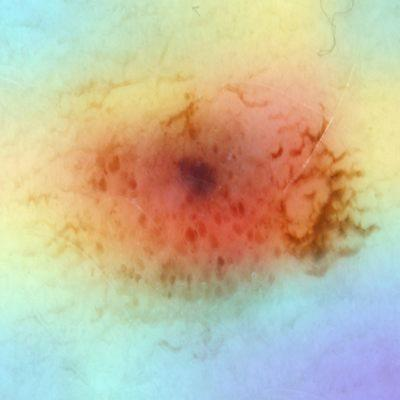

In [71]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032878.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

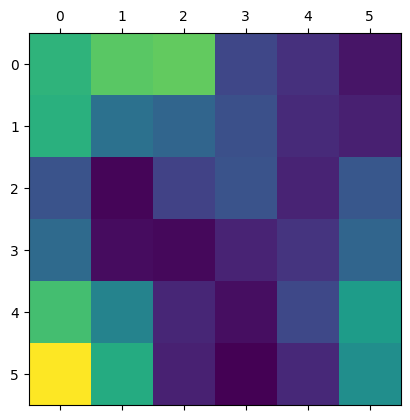

/tmp/ipykernel_31/1849139172.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


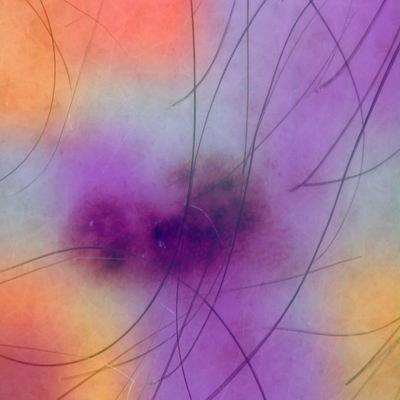

In [72]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032505.jpg'
last_conv_layer_name = "dropout_1"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

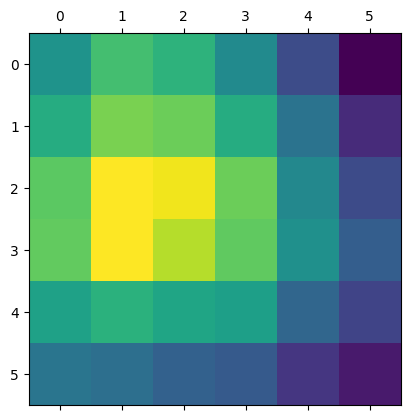

/tmp/ipykernel_31/3377938286.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


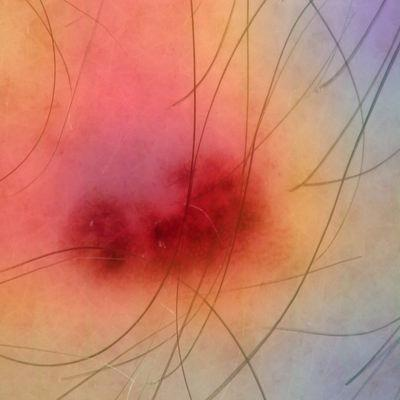

In [73]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032505.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

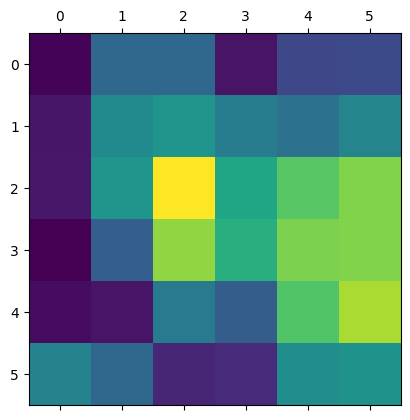

/tmp/ipykernel_31/1662179312.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


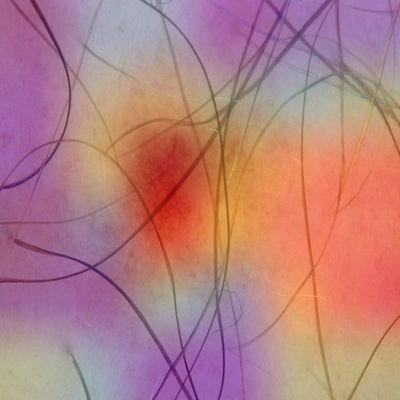

In [76]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032477.jpg'
last_conv_layer_name = "dropout_1"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

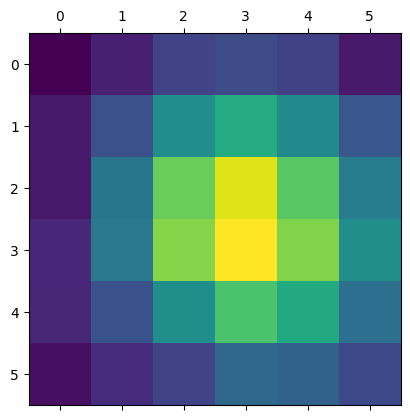

/tmp/ipykernel_31/2571886264.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


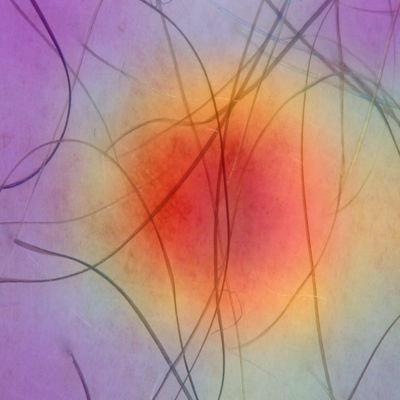

In [78]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032477.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

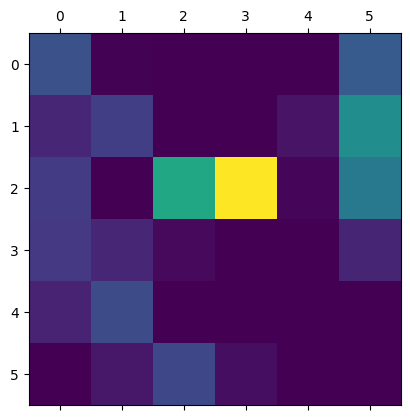

/tmp/ipykernel_31/2219370256.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


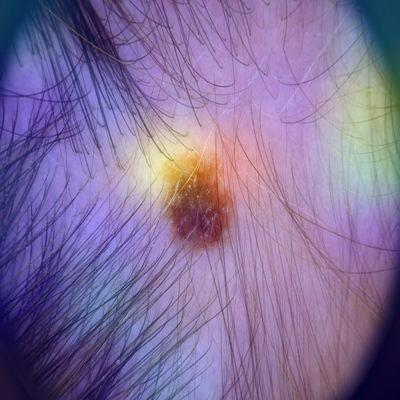

In [80]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032388.jpg'
last_conv_layer_name = "dropout_1"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

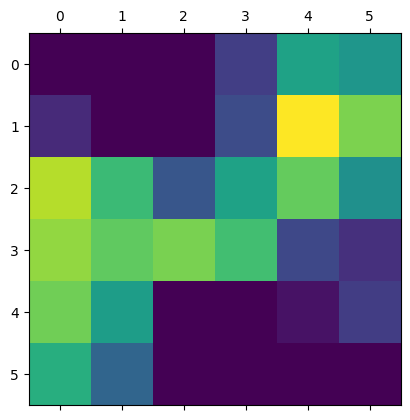

/tmp/ipykernel_31/558037395.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


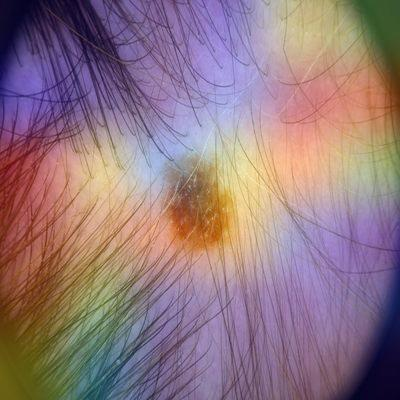

In [81]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/nv/ISIC_0032388.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

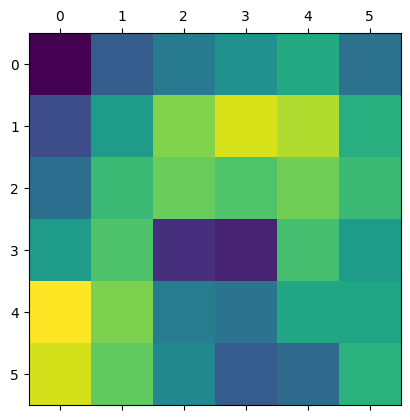

/tmp/ipykernel_31/4015694469.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


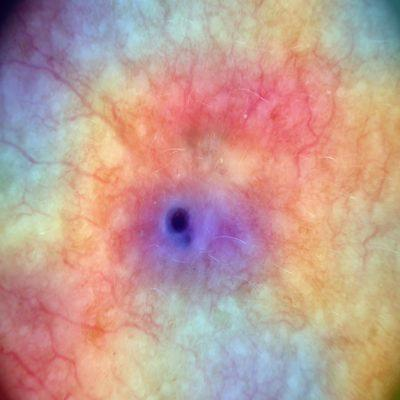

In [86]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/vasc/ISIC_0033230.jpg'
last_conv_layer_name = "dropout_1"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)

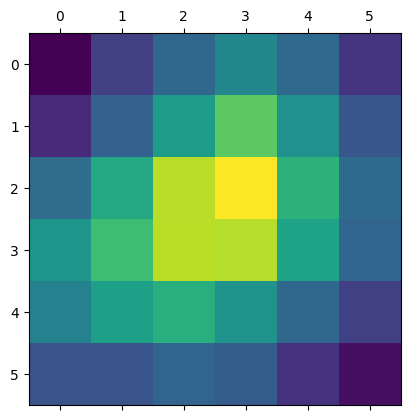

/tmp/ipykernel_31/2101185578.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


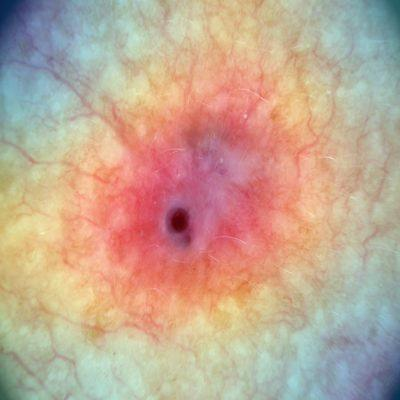

In [87]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))
    
# Define the parameters
img_path = '/kaggle/input/original-ham10000-traintest400/content/HAM10000_Train400/train/vasc/ISIC_0033230.jpg'
last_conv_layer_name = "dropout_64"
img_size = (400, 400)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model1.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)